In [314]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import scipy.optimize as op

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


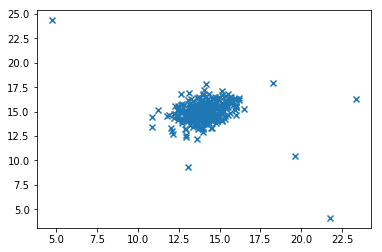

In [315]:
data = loadmat('data/ex8data1.mat')
print(data.keys())
dx = data['X']
plt.scatter(dx[:,0], dx[:,1], marker='x')

In [316]:
def gausParam(x):
    m = x.shape[0]
    mu = np.mean(x, axis=0).reshape(1,x.shape[1])
    
    sum = []
    sigma = np.array([])
    
    for dim in range(x.shape[1]):
        sum.append(0)
    
    for idx, d in enumerate(x):
        for dim in range(x.shape[1]):
            sum[dim] += np.square(d[dim]-mu[:,dim])
    
    for dim in range(x.shape[1]):
        sigma = np.r_[sigma, sum[dim]/m]
        
    sigma = sigma.reshape(1, x.shape[1])
    return mu, sigma

mu, sigma = gausParam(dx)
print(mu, sigma)

[[14.11222578 14.99771051]] [[1.83263141 1.70974533]]


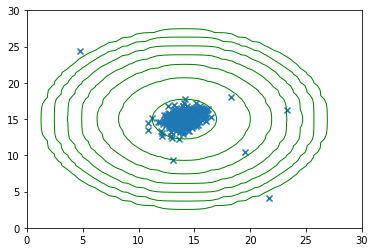

In [317]:
# gaus 1-dimension
def gaus(x, mu, sigma):
    p = 1
    for idx in range(x.shape[1]):
        norm = 1/(2*np.pi*sigma[:,idx])**(1/2)
        val = np.e ** (-(x[:,idx]-mu[:,idx])**2 /(2*sigma[:,idx])) 
        p *= (norm * val)
    return p


def prob(x, mu, sigma):
    z = np.zeros((x.shape[0],1))
    for m in range(x.shape[0]):
        z[m] = gaus(x[m].reshape(1,-1), mu, sigma)
    return z


xgrid = np.linspace(0, 30)
ygrid = np.linspace(0, 30)
xx, yy = np.meshgrid(xgrid, ygrid)
zz = np.c_[xx.ravel(), yy.ravel()]
retz = prob(zz, mu, sigma)

cont_levels = [10**exp for exp in range(-20,0,3)]
    
plt.contour(xx, yy, retz.reshape(xx.shape[0],xx.shape[0]),3,levels = cont_levels, linewidths=1, colors='g')
plt.scatter(dx[:,0], dx[:,1], marker='x')
# plt.scatter(data['Xval'][:,0], data['Xval'][:,1], marker='x', c='red')

Max Epsilon:  0.08990852779269493 Min Epsilon:  4.513250930309782e-36


Optimum Epsilon 8.990852779269493e-05


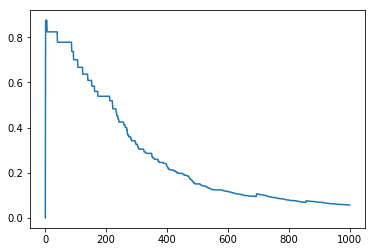

In [318]:
data_cv = data['Xval']
data_label = data['yval']

"""
false : precision != real labeled
true :  precision == real labeled
positive : precise as positive
negative : precise as negative 

    density[m] < e : negative, 
    density[m] >= e : positive
    
    data_label == 0 : real negative, 
    data_label == 1 : real positive
"""

def epsilon(x, mu, sigma):
    density = prob(x, mu, sigma)
    return np.max(density), np.min(density) 


def threshold(x, y, mu, sigma, e):
    density = prob(x, mu, sigma)
    tp=fp=tn=fn=0
    for m in range(density.shape[0]):
        if density[m] < e and y[m] == 0:
            fp += 1
        elif density[m] < e and y[m] == 1:
            tp += 1
        elif density[m] >= e and y[m] == 0:
            tn += 1
        elif density[m] >= e and y[m] == 1:
            fn += 1
    
    if tp == 0 and fp == 0:
        prec = 0
    else:
        prec = tp / (tp + fp)
    
    if tp == 0 and fn == 0:
        rec = 0
    else:
        rec = tp / (tp + fn)
    
    if prec + rec == 0:
        f1 = 0
    else:
        f1 = 2 * prec * rec / (prec + rec)
        
    return f1        
            
DIVISION_NUM = 1000
max_epsilon, min_epsilon = epsilon(data_cv, mu, sigma)
delta = (max_epsilon - min_epsilon)/DIVISION_NUM

print('Max Epsilon: ',max_epsilon, 'Min Epsilon: ',min_epsilon)

t = list(range(DIVISION_NUM+1))

max_f1 = -1 #init max_f1 
the_ep = 0

for i in range(DIVISION_NUM+1):
    e = min_epsilon + i*delta
    t[i] = threshold(data_cv, data_label, mu, sigma, e)
    if t[i] > max_f1:
        the_ep = e
        max_f1 = t[i]

# plt.plot(t[:10])
print('Optimum Epsilon', the_ep)
plt.plot(t)

# dtest = gaus(dx, mu, sigma)
# dcal = 0
# for m in range(dtest.shape[0]):
#     if dtest[m] < the_ep:
#         plt.scatter(dx[m,0], dx[m,1], c='green')

    

In [319]:
data_big = loadmat('data/ex8data2.mat')
dx_big = data_big['X']
cv_big = data_big['Xval']
label_big = data_big['yval']

mu_big, sigma_big = gausParam(dx_big)
density_big = prob(dx_big, mu_big, sigma_big)

max_epsilon_big, min_epsilon_big = epsilon(cv_big, mu_big, sigma_big)
delta_big = (max_epsilon_big - min_epsilon_big)/DIVISION_NUM

print('Max Epsilon: ',max_epsilon_big, 'Min Epsilon: ',min_epsilon_big)

t = -1
max_f1_big = -1 #init max_f1 
the_ep_big = 0

for i in range(DIVISION_NUM+1):
    e = min_epsilon_big + i*delta_big
    t = threshold(cv_big, label_big, mu_big, sigma_big, e)
    if t > max_f1_big:
        the_ep_big = e
        max_f1_big = t

print('Optimum Epsilon', the_ep_big)

outlier = 0
for m in range(density_big.shape[0]):
    if density_big[m] < the_ep_big:
        outlier += 1
        
print('outlier : ',outlier)
print('=============')
# res_big = op.fminbound(opt_threshold, min_epsilon_big, max_epsilon_big)
res_big = res = op.minimize_scalar(opt_threshold, method='bounded', bounds=(min_epsilon_big, max_epsilon_big))

outlier_optimize = 0
for m in range(density_big.shape[0]):
    if density_big[m] < res_big.x:
        outlier_optimize += 1
print('Optimum Epsilon', res_big)
print('outlier : ',outlier_optimize)
        

Max Epsilon:  1.3772288312874004e-15 Min Epsilon:  5.953349076111424e-26


Optimum Epsilon 1.3772288907613575e-18
outlier :  117
Optimum Epsilon      fun: -0.3636363636363636
 message: 'Solution found.'
    nfev: 1
  status: 0
 success: True
       x: 5.260546033022859e-16
outlier :  932


In [321]:
def opt_threshold(e):
    density = prob(x, mu, sigma)
    tp=fp=tn=fn=0
    for m in range(density.shape[0]):
        if density[m] < e and y[m] == 0:
            fp += 1
        elif density[m] < e and y[m] == 1:
            tp += 1
        elif density[m] >= e and y[m] == 0:
            tn += 1
        elif density[m] >= e and y[m] == 1:
            fn += 1
    
    if tp == 0 and fp == 0:
        prec = 0
    else:
        prec = tp / (tp + fp)
    
    if tp == 0 and fn == 0:
        rec = 0
    else:
        rec = tp / (tp + fn)
    
    if prec + rec == 0:
        f1 = 0
    else:
        f1 = 2 * prec * rec / (prec + rec)
        
    return -f1   

x = data_cv
y = data_label
mu = mu
sigma = sigma

print(min_epsilon, max_epsilon, mu, sigma)
# res = op.minimize(opt_threshold, max_epsilon, jac=opt_threshold, method='BFGS')
# res = op.minimize_scalar(opt_threshold, bounds=(min_epsilon, max_epsilon), method='bounded')
# print(res)
# res = op.fminbound(opt_threshold, min_epsilon, max_epsilon)
res = op.minimize_scalar(opt_threshold, method='bounded', bounds=(min_epsilon, max_epsilon))
# print(opt_threshold(res))
# print(opt_threshold(8.990852779269493e-05))
print(res)

4.513250930309782e-36 0.08990852779269493 [[14.11222578 14.99771051]] [[1.83263141 1.70974533]]
     fun: -0.823529411764706
 message: 'Solution found.'
    nfev: 19
  status: 0
 success: True
       x: 0.0022257704116956
